# Щука 2014-2017

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt


## Integrate data - Read data from csv 

In [2]:
def removeHeaderRows(data_raw):
    data_raw.drop(data_raw.index[[0,1,2,3,4]], inplace=True)
        
def removeSingleValueColumn(col_name, data):
    if (len(data[col_name].unique()) == 1):
        print('remove column: ', col_name)
        return data.drop(col_name, 1)

In [3]:
#read raw data
from pandas import read_csv
data_raw2014 = read_csv("C:\\Users\\User\\Documents\\imagineML\\data\\current\\data2014.csv") #щука
data_raw2015 = read_csv("C:\\Users\\User\\Documents\\imagineML\\data\\current\\data2015.csv")
data_raw2016 = read_csv("C:\\Users\\User\\Documents\\imagineML\\data\\current\\data2016.csv")
data_raw2017 = read_csv("C:\\Users\\User\\Documents\\imagineML\\data\\current\\data2017.csv")
totalrows = data_raw2014.shape[0] + data_raw2015.shape[0] + data_raw2016.shape[0] + data_raw2017.shape[0]
print("~rows: ",totalrows)

removeHeaderRows(data_raw2014)
removeHeaderRows(data_raw2015)
removeHeaderRows(data_raw2016)
removeHeaderRows(data_raw2017)

df = pd.concat([data_raw2014, data_raw2015, data_raw2016, data_raw2017], axis=0)
df = df.reset_index(drop=True)
print("actual rows: ", df.shape[0])

df.columns = ['date', 'col1', 'warehouse', 'col2', 'name', 'col3', 'id', 'qtyBefore', 'qty']
df = removeSingleValueColumn('col1', df)
df = removeSingleValueColumn('col2', df)
df = removeSingleValueColumn('col3', df)
df = removeSingleValueColumn('warehouse', df)
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df['date'] = df['date'].dt.date
df['qtyBefore'] = df['qtyBefore'].astype('float')
df['qty'] = df['qty'].astype('float')
df['month'] = df['date'].map(lambda x: x.month)
df['year'] = df['date'].map(lambda x: x.year)
#TODO df['dayofweek'] = df['date'].map(lambda x: x.year)
df.head()


~rows:  96579
actual rows:  96559
remove column:  col1
remove column:  col2
remove column:  col3
remove column:  warehouse


,date,name,id,qtyBefore,qty,month,year
0,2014-07-11,Батарейки мизинчиковые ААА LR03 12 в уп. бата...,УТ000001012,144.0,3.0,7,2014
1,2014-07-11,Блокнотик Светская львица,СК-00001146,1.0,1.0,7,2014
2,2014-07-11,Визитница Для покупочек,01-00002742,2.0,1.0,7,2014
3,2014-07-11,Визитница Мои скидочки,01-00000889,2.0,1.0,7,2014
4,2014-07-11,Визитница Особы приближенные к императору,УТ000000026,2.0,1.0,7,2014


In [4]:
#release memory
del [data_raw2014,data_raw2015, data_raw2016, data_raw2017]

# Descriptive statistics

In [5]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [6]:
#analysis
print(color.BOLD + color.PURPLE + 'Features - type' + color.END)
print(df.info())
print(color.BOLD + color.PURPLE + 'Numeric features - type' + color.END)
print(df.describe())
print(color.BOLD + color.PURPLE + 'Non-numeric features - type'+ color.END)
print(df.describe(include=['object', 'bool']))
print(color.BOLD + color.PURPLE + 'Dates' + color.END)
min_date = df['date'].min() 
max_date = df['date'].max() 
months = (max_date.year - min_date.year) * 12 + max_date.month - min_date.month
print(min_date, max_date, "~",months, "months")
days = max_date - min_date
print(days)

Features - type
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96559 entries, 0 to 96558
Data columns (total 7 columns):
date         96559 non-null object
name         96559 non-null object
id           96559 non-null object
qtyBefore    96325 non-null float64
qty          96559 non-null float64
month        96559 non-null int64
year         96559 non-null int64
dtypes: float64(2), int64(2), object(3)
memory usage: 5.2+ MB
None
Numeric features - type
          qtyBefore           qty         month          year
count  96325.000000  96559.000000  96559.000000  96559.000000
mean      17.721915      1.363044      7.037355   2015.538717
std       43.134274      1.271382      3.716089      0.984569
min      -36.000000      0.001000      1.000000   2014.000000
25%        3.000000      1.000000      4.000000   2015.000000
50%        6.000000      1.000000      7.000000   2016.000000
75%       13.000000      1.000000     11.000000   2016.000000
max      592.000000     85.000000     12.000

### Данные

+ Данные за 37 месяцев [2014-07-11; 2017-08-20]
+ 4976 товаров
+ В среднем продается одна единица товара за операцию

## NAMES PRODUCT

In [7]:
namescount = len(df['name'].unique())
idscount = len(df['id'].unique())
print('names count:', namescount, 'ids count:', idscount)
names = df[['id','name']]
print('length: ', len(names))
names = names.drop_duplicates().dropna()
print('length: ', len(names))

names count: 4976 ids count: 4976
length:  96559
length:  4976


## Visualization

In [8]:
 # будем отображать графики прямо в jupyter'e
%pylab inline

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


year  month
2014  7        1399.000
      8        3059.000
      9        3544.000
      10       3705.000
      11       3216.000
      12       8686.000
2015  1        2907.000
      2        4717.500
      3        3335.000
      4        2629.000
      5        2498.000
      6        2449.000
      7        2634.000
      8        2787.000
      9        2779.000
      10       2746.000
      11       2560.000
      12       9037.000
2016  1        2616.000
      2        5249.000
      3        2922.000
      4        2280.000
      5        2310.000
      6        2236.000
      7        2336.000
      8        2841.000
      9        2624.000
      10       3001.000
      11       3278.000
      12       8914.010
2017  1        2548.001
      2        5793.000
      3        3653.000
      4        3218.000
      5        2886.000
      6        2951.000
      7        3028.700
Name: qty, dtype: float64

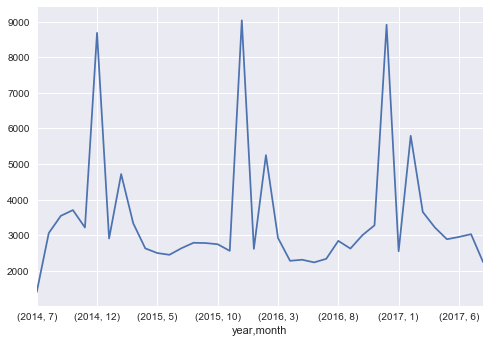

In [9]:
sales_day = df.groupby(['date'])['qty'].sum()
sales_month = df.groupby(by=[df['year'],df['month']])['qty'].sum()
sales_month.plot()
sales_month.head(37)

year
2014    23609.000
2015    41078.500
2016    40607.010
2017    26319.701
Name: qty, dtype: float64

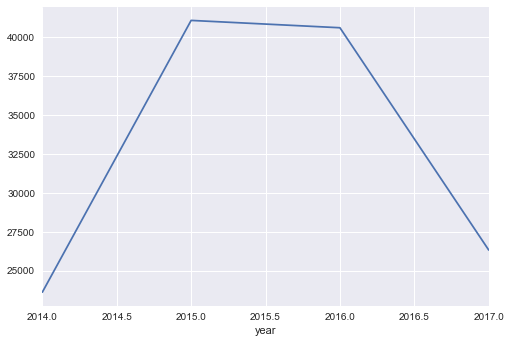

In [10]:
sales_year = df.groupby(['year'])['qty'].sum()
sales_year.plot()
sales_year.head(4)

#### timeseries

date
2014-07-11    33
2014-07-12    60
2014-07-13    52
2014-07-14    53
2014-07-15    50
2014-07-16    48
2014-07-17    55
2014-07-18    73
2014-07-19    85
2014-07-20    49
2014-07-21    36
2014-07-22    66
2014-07-23    48
2014-07-24    47
2014-07-25    57
2014-07-26    43
2014-07-27    64
2014-07-28    62
2014-07-29    43
2014-07-30    50
2014-07-31    49
2014-08-01    72
2014-08-02    76
2014-08-03    58
2014-08-04    69
2014-08-05    59
2014-08-06    74
2014-08-07    74
2014-08-08    64
2014-08-09    86
2014-08-10    56
2014-08-11    66
2014-08-12    75
2014-08-13    62
2014-08-14    69
2014-08-15    74
2014-08-16    63
2014-08-17    53
2014-08-18    58
2014-08-19    60
2014-08-20    61
2014-08-21    34
2014-08-22    62
2014-08-23    77
2014-08-24    76
2014-08-25    54
2014-08-26    40
2014-08-27    74
2014-08-28    94
2014-08-29    93
Name: id, dtype: int64

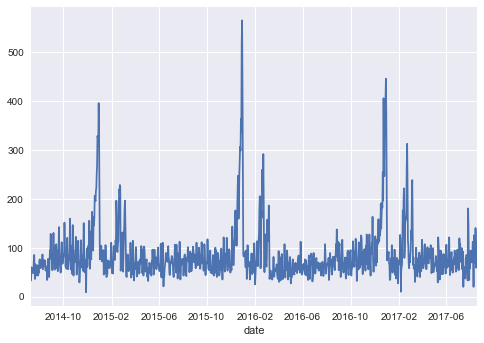

In [11]:
items_per_day = df.groupby('date')['id'].count()
items_per_day.plot()
items_per_day.head(50)

year  month
2014  7        1123
      8        2138
      9        2471
      10       2636
      11       2264
      12       5375
2015  1        2196
      2        3244
      3        2514
      4        2113
      5        2034
      6        1977
      7        2174
      8        2285
      9        2303
      10       2220
      11       2115
      12       6148
2016  1        2092
      2        3543
      3        2119
      4        1836
      5        1848
      6        1824
      7        1940
      8        2288
      9        2098
      10       2403
      11       2545
      12       5897
2017  1        1969
      2        3551
      3        2583
      4        2357
      5        2151
      6        2208
      7        2309
      8        1668
Name: id, dtype: int64

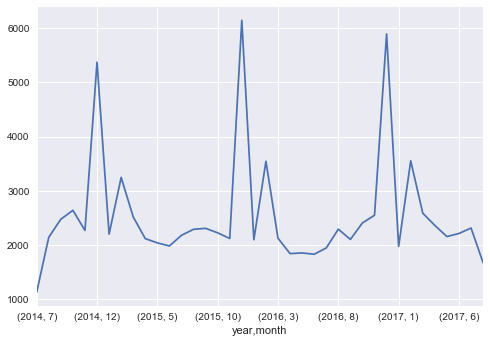

In [12]:
items_per_month = df.groupby(by=[df['year'],df['month']])['id'].count()
items_per_month.plot()
items_per_month.head(50)

year
2014    16007
2015    31323
2016    30433
2017    18796
Name: id, dtype: int64

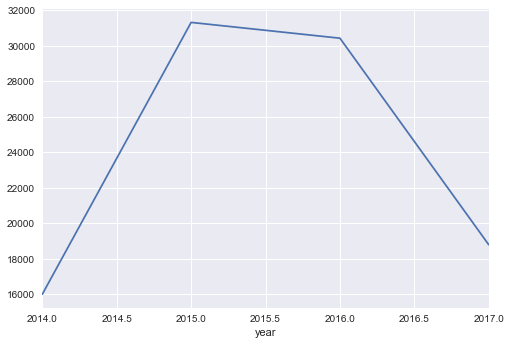

In [13]:
items_per_year = df.groupby(['year'])['id'].count()
items_per_year.plot()
items_per_year.head()

In [14]:
qty = df[['date', 'id', 'name', 'qty']]
qty = qty.groupby(['id', 'date', 'name'])['qty'].sum()
qty = qty.to_frame().reset_index()
qty_ts = qty.pivot(index='date', columns='id', values='qty')
qty_ts.rename(columns=lambda col: "qty_" + col, inplace=True)
#qty_ts
qtyBefore = df[['date', 'id', 'name', 'qtyBefore']]
qtyBefore = qtyBefore.groupby(['id', 'date', 'name'])['qtyBefore'].max()
qtyBefore = qtyBefore.to_frame().reset_index()
qtyBefore_ts = qtyBefore.pivot(index='date', columns='id', values='qtyBefore')
qtyBefore_ts.rename(columns=lambda col: "qtyBfr_" + col, inplace=True)
#qtyBefore_ts
ts_per_day = pd.concat([qty_ts,qtyBefore_ts], axis=1).fillna(0)

In [15]:
df.head()
qty_month = df[['id', 'name', 'qty', 'date', 'month', 'year']]
qty_month['month_str'] = qty_month['month'].astype(str)
qty_month['year_str'] = qty_month['year'].astype(str)
qty_month['key'] = qty_month['year_str'] + "-" + qty_month['month_str'] + "-1"
qty_month['month_date'] = pd.to_datetime(qty_month['key'], format='%Y-%m-%d')
qty_month = qty_month.groupby(['id', 'month_date'])['qty'].sum()
qty_month = qty_month.to_frame().reset_index()
qty_month.head(100)
qty_month_ts = qty_month.pivot(index='month_date', columns='id', values='qty')

## Empty Values

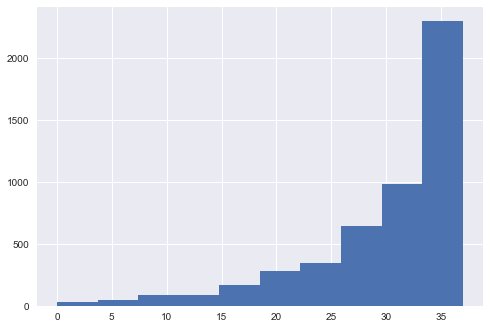

In [16]:
isNan = qty_month_ts.isnull().sum().sort_values(ascending=False)
isNan.hist()

#### Более 2000 продуктов имеют только продажи в месяцах - исключаем из прогноза

In [17]:
# to_drop = isNan[isNan >= 35]
# to_drop_columns = to_drop.index #1931
# qty_month_ts = qty_month_ts.drop(to_drop_columns, axis=1)
# qty_month_ts #3045
to_drop = isNan[isNan > 0] 
to_drop_columns = to_drop.index 
qty_month_ts = qty_month_ts.drop(to_drop_columns, axis=1)

#### 12 продуктов точно будут включены в заказ

In [18]:
most_sold = isNan[isNan == 0]
names[names['id'].isin(most_sold.index.values)]

,id,name
0,УТ000001012,Батарейки мизинчиковые ААА LR03 12 в уп. бата...
18,СК-00000830,Напиток Доктор Пеппер (в пачке 12 шт.)
135,УТ000000747,Радуга Слинки
146,УТ000001013,Батарейки пальчиковые АА LR06 16 в уп. батарейка
191,СК-00000452,Туалетная бумага 100 долларов
231,СК-00000110,Ночник Звездное небо
233,06-00000125,Пакет Самый лучший подарок рыжий S
238,УТ000000749,Рулетка пьяная с рюмками(стекло)
318,01-00002130,Монета Да/Нет
574,РТ-00000009,Мыльные пузыри нелопающиеся (5 шт. в пачке)


In [19]:
qty_month_ts

id,00-00000406,01-00000656,01-00002130,06-00000125,РТ-00000009,СК-00000110,СК-00000452,СК-00000830,УТ000000747,УТ000000749,УТ000001012,УТ000001013
month_date,,,,,,,,,,,,
2014-07-01,3.0,2.0,2.0,1.0,46.0,5.0,13.000,17.0,10.0,4.0,19.0,53.0
2014-08-01,12.0,3.0,5.0,3.0,163.0,8.0,42.000,59.0,25.0,8.0,107.0,104.0
2014-09-01,34.0,3.0,6.0,4.0,249.0,8.0,27.000,35.0,56.0,2.0,129.0,80.0
2014-10-01,19.0,5.0,4.0,6.0,130.0,10.0,22.000,67.0,23.0,8.0,126.0,127.0
2014-11-01,22.0,4.0,1.0,5.0,151.0,7.0,32.000,52.0,26.0,8.0,81.0,98.0
2014-12-01,83.0,10.0,6.0,11.0,209.0,28.0,104.000,46.0,93.0,13.0,324.0,254.0
2015-01-01,24.0,6.0,6.0,3.0,147.0,7.0,14.000,32.0,39.0,6.0,85.0,67.0
2015-02-01,22.0,4.0,7.0,22.0,136.0,9.0,29.000,52.0,24.0,7.0,110.0,108.0
2015-03-01,23.0,13.0,6.0,9.0,90.0,6.0,31.000,27.0,21.0,6.0,65.0,79.0


In [20]:
qty_month_ts.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

id,00-00000406,01-00000656,01-00002130,06-00000125,РТ-00000009,СК-00000110,СК-00000452,СК-00000830,УТ000000747,УТ000000749,УТ000001012,УТ000001013
id,,,,,,,,,,,,
00-00000406,1.0,0.34,0.079,0.26,0.73,0.64,0.63,0.33,0.9,0.48,0.86,0.78
01-00000656,0.34,1.0,0.062,-0.12,0.32,5.3e-05,0.091,-0.036,0.14,-0.035,0.057,0.089
01-00002130,0.079,0.062,1.0,0.29,-0.053,0.56,0.54,-0.082,0.16,0.44,0.28,0.41
06-00000125,0.26,-0.12,0.29,1.0,-0.00063,0.35,0.44,0.073,0.18,0.45,0.36,0.34
РТ-00000009,0.73,0.32,-0.053,-0.00063,1.0,0.32,0.39,0.38,0.69,0.25,0.57,0.52
СК-00000110,0.64,5.3e-05,0.56,0.35,0.32,1.0,0.92,0.28,0.63,0.81,0.8,0.88
СК-00000452,0.63,0.091,0.54,0.44,0.39,0.92,1.0,0.31,0.64,0.85,0.78,0.87
СК-00000830,0.33,-0.036,-0.082,0.073,0.38,0.28,0.31,1.0,0.38,0.3,0.46,0.43
УТ000000747,0.9,0.14,0.16,0.18,0.69,0.63,0.64,0.38,1.0,0.46,0.87,0.79


In [21]:
qty_month_ts.describe()

id,00-00000406,01-00000656,01-00002130,06-00000125,РТ-00000009,СК-00000110,СК-00000452,СК-00000830,УТ000000747,УТ000000749,УТ000001012,УТ000001013
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,13.605263,5.263158,6.000000,6.552632,82.184211,7.394737,24.842132,25.263158,21.526316,5.447368,66.078947,68.210526
std,14.332989,4.259706,3.377189,5.181554,56.793536,6.314032,27.713315,18.990302,15.822900,3.569369,56.384482,46.966439
min,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,2.000000,8.000000,1.000000,19.000000,11.000000
25%,4.250000,2.000000,4.000000,3.000000,40.750000,4.250000,12.000000,13.000000,11.500000,3.000000,33.250000,43.500000
50%,10.000000,3.500000,5.500000,5.000000,74.500000,6.000000,15.500000,18.000000,16.000000,4.500000,46.000000,52.500000
75%,19.750000,8.000000,6.000000,8.750000,113.000000,8.000000,27.000000,33.500000,25.000000,6.000000,79.000000,78.750000
max,83.000000,15.000000,19.000000,24.000000,249.000000,32.000000,144.000000,88.000000,93.000000,18.000000,324.000000,254.000000


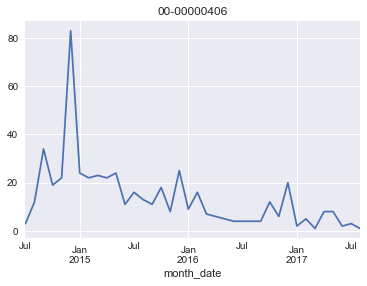

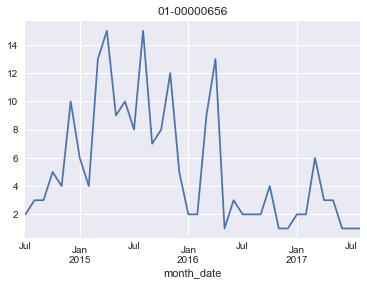

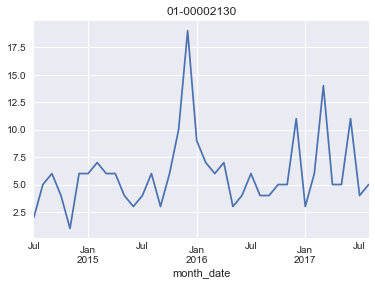

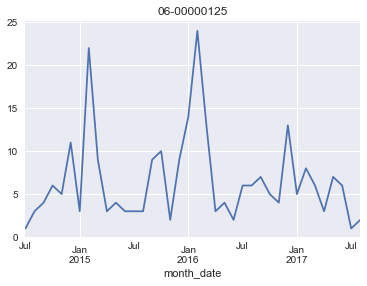

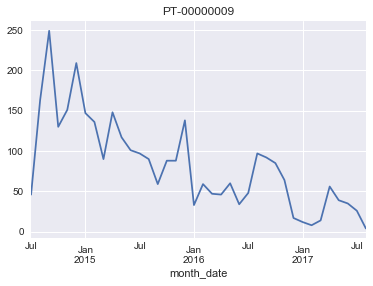

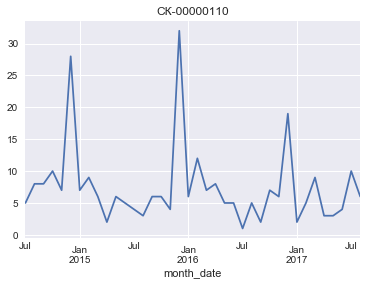

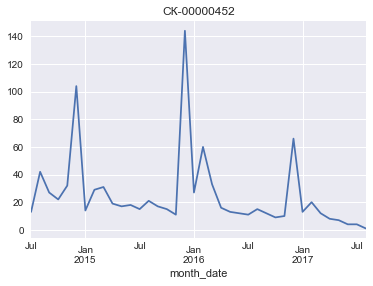

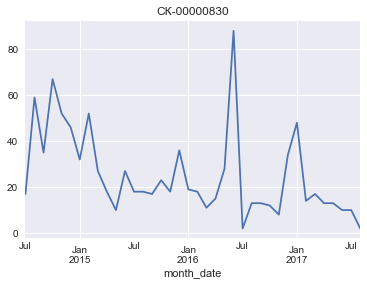

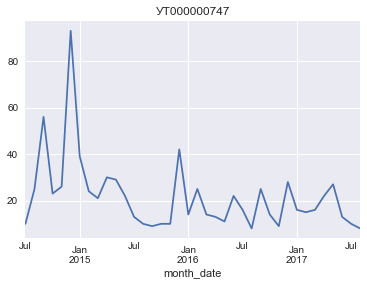

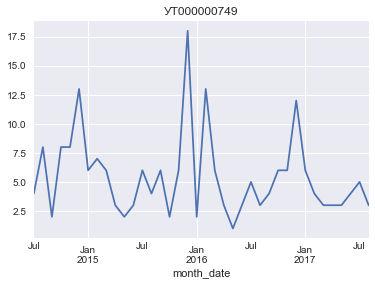

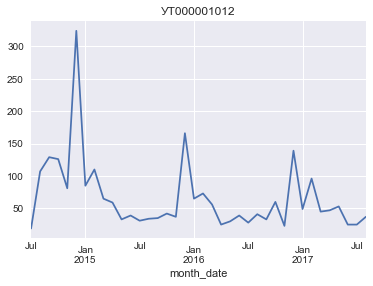

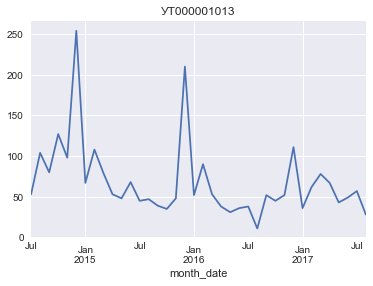

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

for column in qty_month_ts.columns:
    qty_month_ts[column].plot(title=column)
    plt.show()


In [23]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        test = sm.tsa.adfuller(y)
        print('adf: ', test[0])
        print("Критерий Дики-Фуллера: p=%f" % test[1])
        print('Critical values: ', test[4])
        if test[0]> test[4]['5%']: 
            print('есть единичные корни, ряд не стационарен')
        else:
            print('единичных корней нет, ряд стационарен')

        plt.tight_layout()
    return 

adf:  -4.56047015472
Критерий Дики-Фуллера: p=0.000153
Critical values:  {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
единичных корней нет, ряд стационарен


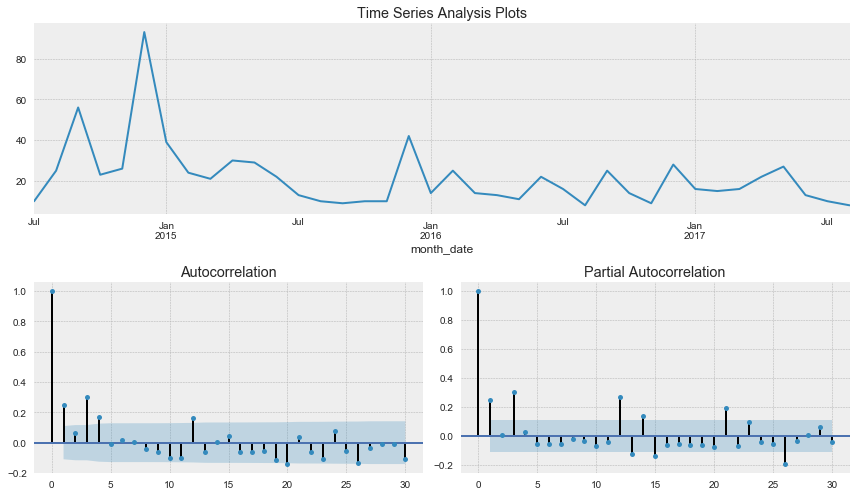

In [24]:
tsplot(qty_month_ts['УТ000000747'], lags=30)

adf:  -5.71910469604
Критерий Дики-Фуллера: p=0.000001
Critical values:  {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
единичных корней нет, ряд стационарен


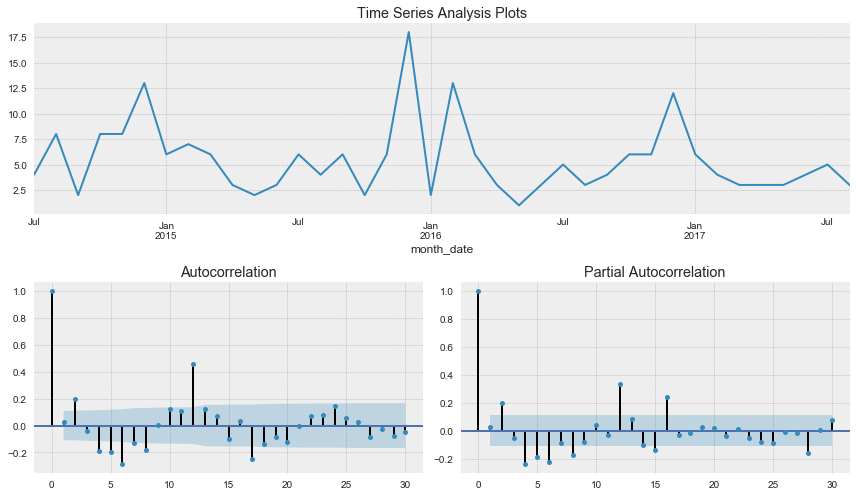

In [25]:
tsplot(qty_month_ts['УТ000000749'], lags=30)

adf:  -2.4289983491
Критерий Дики-Фуллера: p=0.133719
Critical values:  {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
есть единичные корни, ряд не стационарен


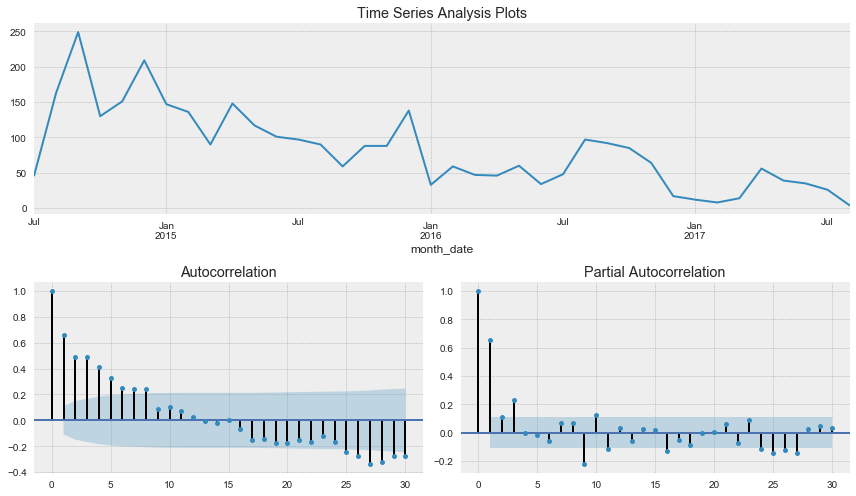

In [26]:
tsplot(qty_month_ts['РТ-00000009'], lags=30)

adf:  -1.56671951657
Критерий Дики-Фуллера: p=0.500286
Critical values:  {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}
есть единичные корни, ряд не стационарен


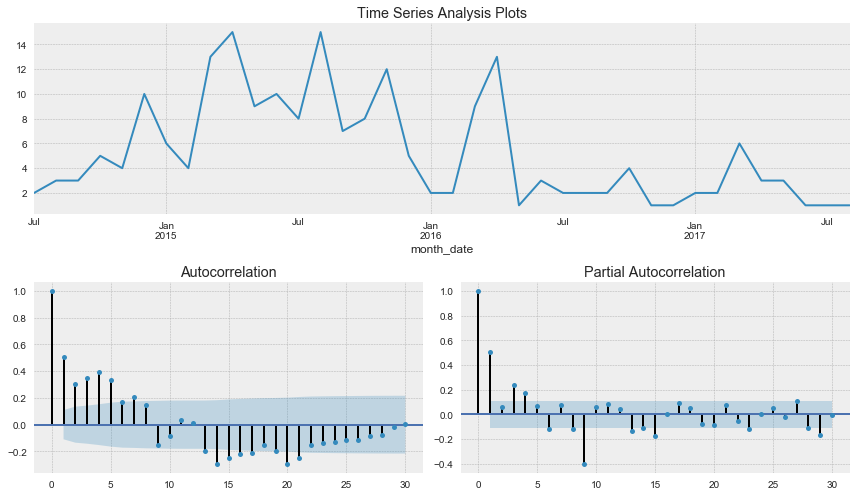

In [27]:
tsplot(qty_month_ts['01-00000656'], lags=30)

adf:  -6.32496204518
Критерий Дики-Фуллера: p=0.000000
Critical values:  {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
единичных корней нет, ряд стационарен


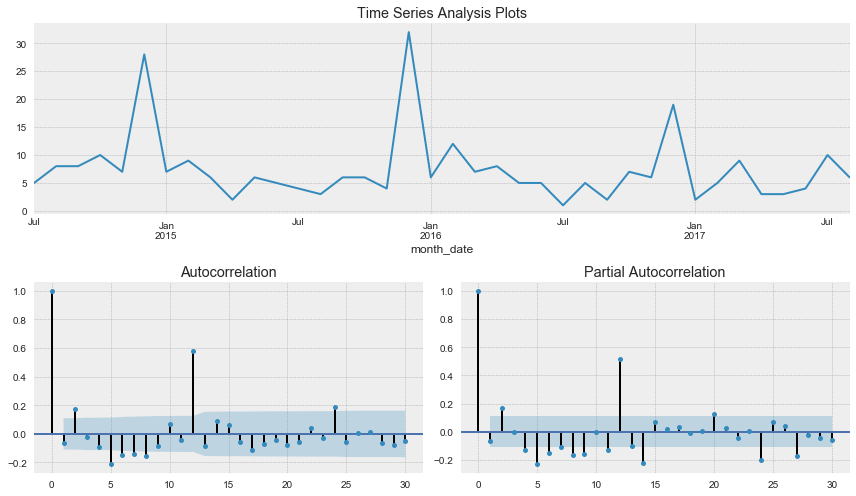

In [28]:
tsplot(qty_month_ts['СК-00000110'], lags=30)

adf:  -2.48547543317
Критерий Дики-Фуллера: p=0.119048
Critical values:  {'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}
есть единичные корни, ряд не стационарен


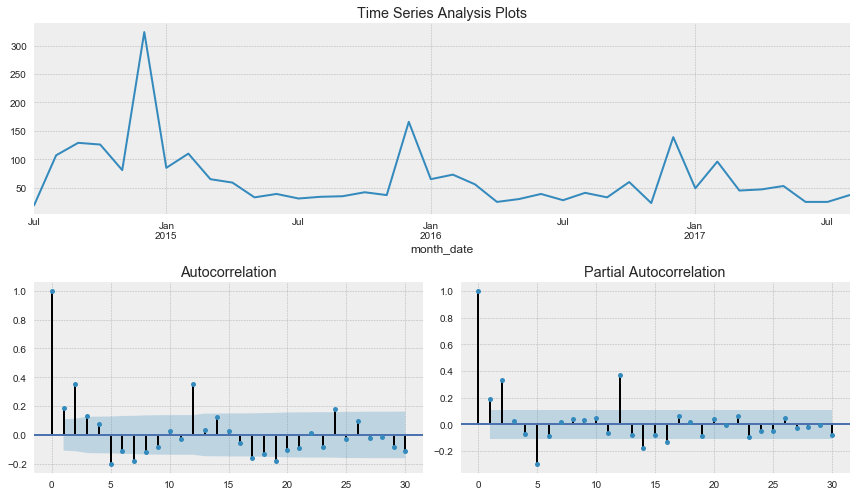

In [29]:
tsplot(qty_month_ts['УТ000001012'], lags=30)

adf:  -5.07555002006
Критерий Дики-Фуллера: p=0.000016
Critical values:  {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
единичных корней нет, ряд стационарен


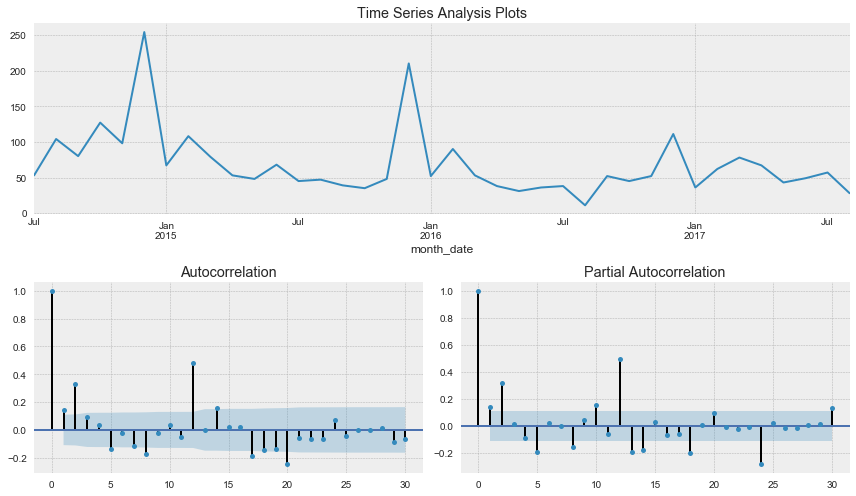

In [30]:
tsplot(qty_month_ts['УТ000001013'], lags=30)

adf:  -4.51654734611
Критерий Дики-Фуллера: p=0.000184
Critical values:  {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
единичных корней нет, ряд стационарен


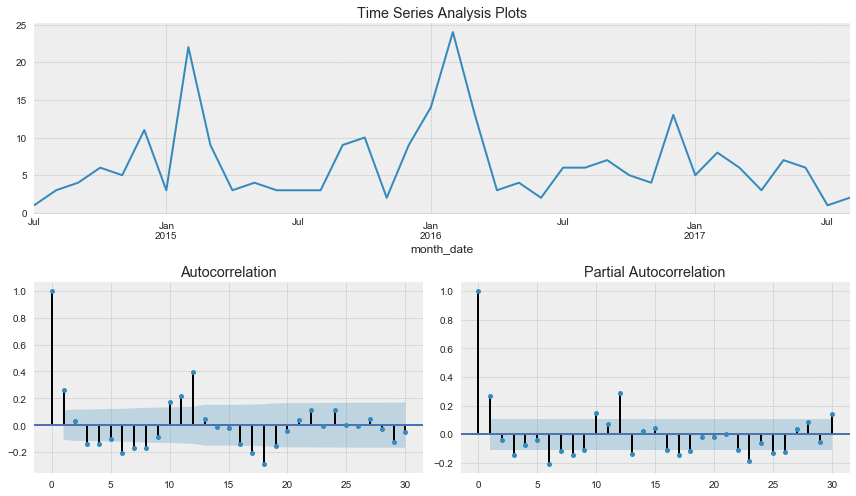

In [31]:
tsplot(qty_month_ts['06-00000125'], lags=30)

adf:  -4.46563006939
Критерий Дики-Фуллера: p=0.000227
Critical values:  {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
единичных корней нет, ряд стационарен


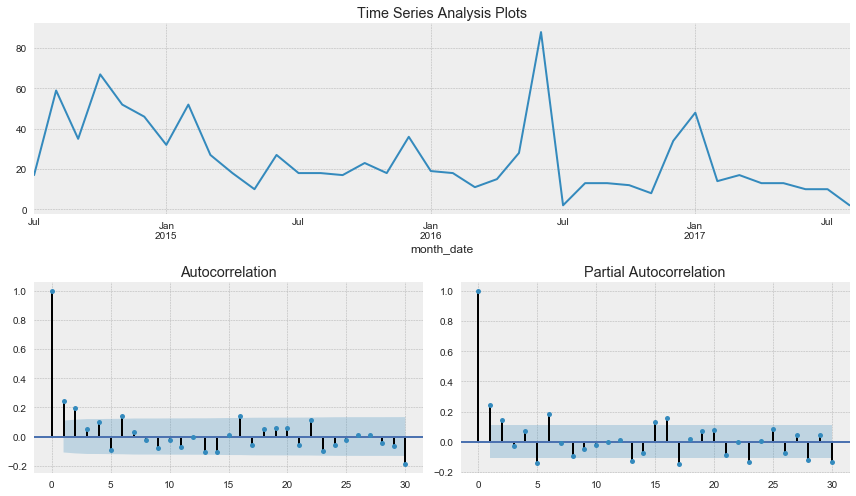

In [32]:
tsplot(qty_month_ts['СК-00000830'], lags=30)

adf:  -2.49190426802
Критерий Дики-Фуллера: p=0.117457
Critical values:  {'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}
есть единичные корни, ряд не стационарен


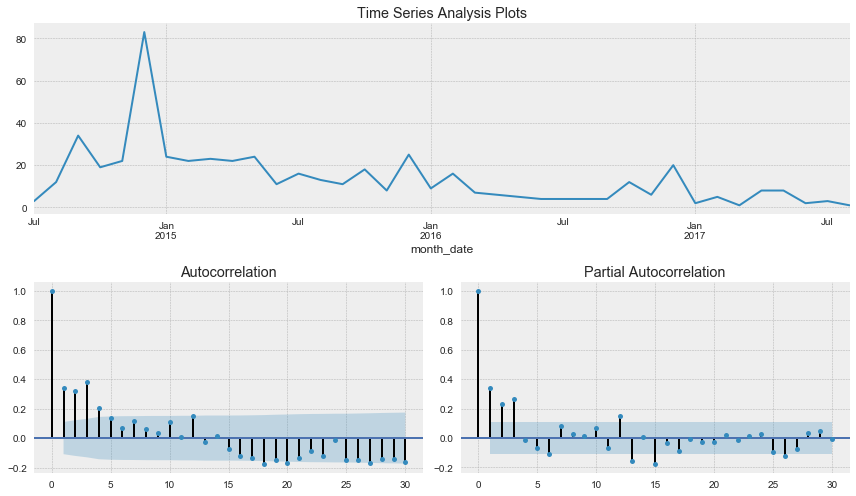

In [33]:
tsplot(qty_month_ts['00-00000406'], lags=30)

adf:  -5.70839343481
Критерий Дики-Фуллера: p=0.000001
Critical values:  {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
единичных корней нет, ряд стационарен


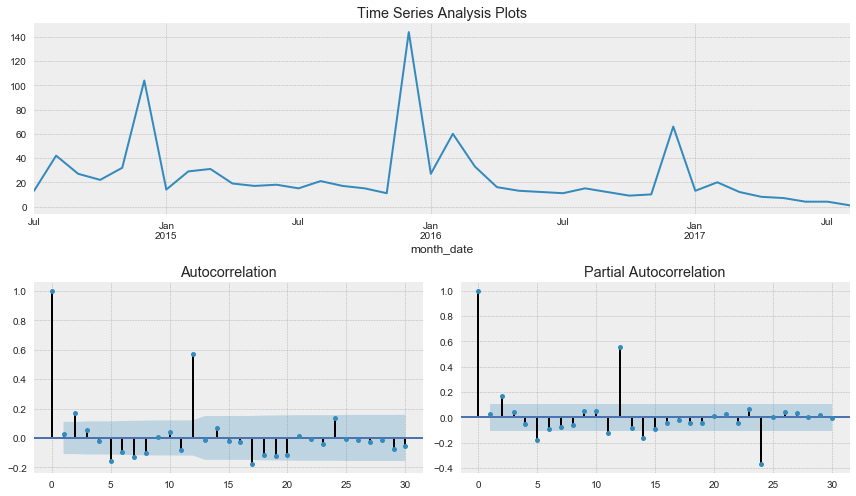

In [34]:
tsplot(qty_month_ts['СК-00000452'], lags=30)

adf:  -4.85666452553
Критерий Дики-Фуллера: p=0.000042
Critical values:  {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
единичных корней нет, ряд стационарен


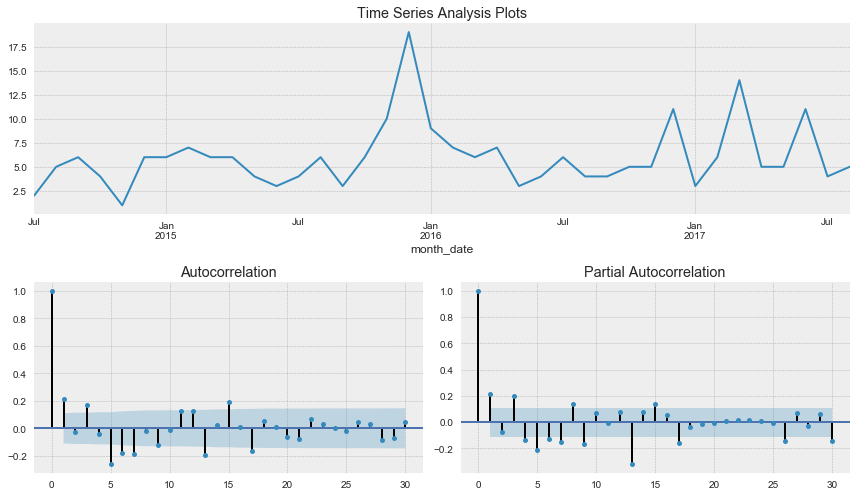

In [35]:
tsplot(qty_month_ts['01-00002130'], lags=30)

# Linear regression

adf:  -5.15705284724
Критерий Дики-Фуллера: p=0.000011
Critical values:  {'1%': -3.4362442981669505, '5%': -2.864142643826014, '10%': -2.5681557248913101}
единичных корней нет, ряд стационарен


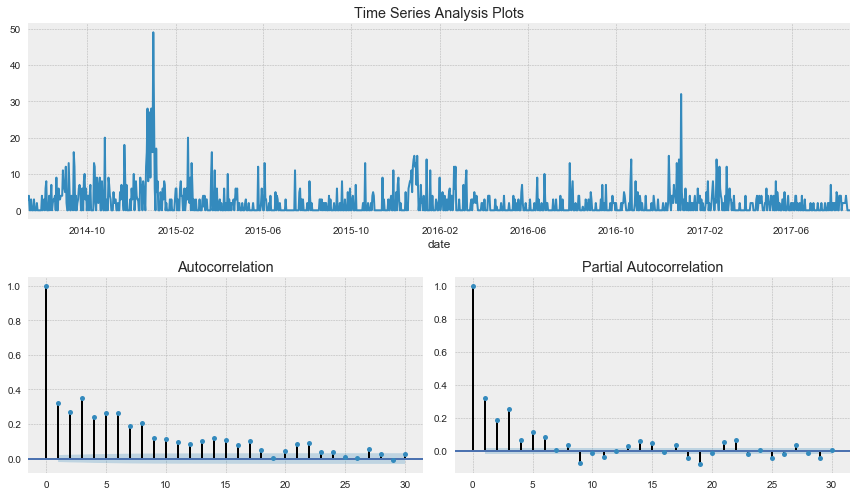

In [36]:
#УТ000001012
ts1 = ts_per_day[['qty_УТ000001012', 'qtyBfr_УТ000001012']]
tsplot(ts1['qty_УТ000001012'], lags=30)

In [37]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    data.index = data.index.to_datetime()
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1

    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))

    # выкидываем закодированные средними признаки 
    data.drop(["weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

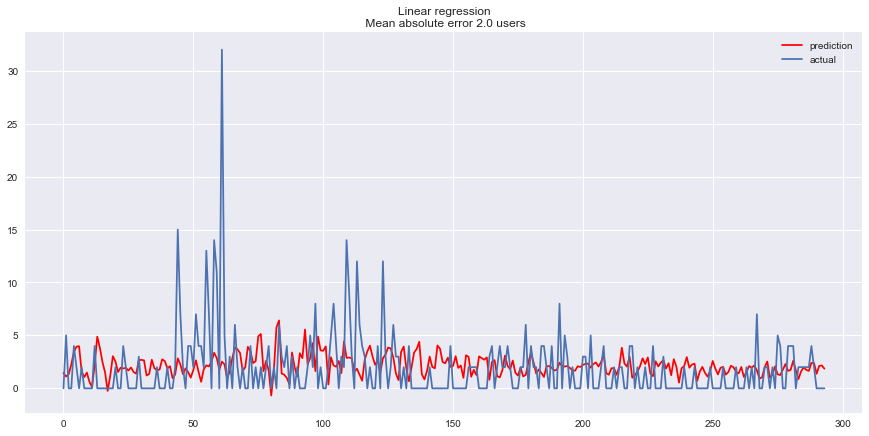

In [38]:
from sklearn.linear_model import LinearRegression
batareiki = ts1['qty_УТ000001012'].astype(float)

X_train, X_test, y_train, y_test = prepareData(batareiki, test_size=0.3, lag_start=12, lag_end=48)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);


In [39]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [40]:
%%time
performTimeSeriesCV(X_train, y_train, 5, lr, mean_absolute_error)

Size train set: (794, 38)
Size of each fold: 158

Splitting the first 2 chunks at 1/2
Size of train + test: (316, 38)

Splitting the first 3 chunks at 2/3
Size of train + test: (474, 38)

Splitting the first 4 chunks at 3/4
Size of train + test: (632, 38)

Splitting the first 5 chunks at 4/5
Size of train + test: (790, 38)
Wall time: 81.1 ms


3.3920563720518087

In [46]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [101]:


def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):

    # исходные данные
    X_train, X_test, y_train, y_test = prepareData(dataset.Users, lag_start, lag_end, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

ModuleNotFoundError: No module named 'xgboost'

# FORECASTING!!!

In [122]:
qty_month_ts.to_csv("C:\\Users\\User\\Documents\\imagineML\\data\\current\\monthly_qty.csv", sep='\t', encoding='utf-8')

In [60]:
#release memory
del qty
del qtyBefore
del qty_ts
del qtyBefore_ts
del df